Tutorial on Computing HFOs
==========================

In this tutorial, we will walk through how to compute HFOs on a sample dataset that is defined in [1]. 

We will demonstrate usage of the following detectors:

- Line Length detector
- RMS detector
- Morphology detector (used in the paper)

Dataset Preprocessing
---------------------
Note that the data has been converted to BIDS to facilitate easy loading using ``mne-bids`` package. Another thing to note is that the authors in this dataset 
reported HFOs detected using bipolar montage. In addition, they only analyzed HFOs for a subset of the recording channels.

In order to compare results to a monopolar reference, we define an HFO to be "found" if there was an HFO in either of the corresponding bipolar contacts.

References
----------
[1] Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient.
Scientific Reports. 2017;7(1):13836.
https://www.nature.com/articles/s41598-017-13064-1
doi:10.1038/s41598-017-13064-1

In [117]:
# first let's load in all our packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from mne_bids import (read_raw_bids, BIDSPath, 
                      get_entity_vals, get_datatypes, 
                      make_report)
from mne_bids.stats import count_events

import mne
from mne import make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import simulate_raw, add_noise, simulate_sparse_stc

basepath = os.path.join(os.getcwd(), "../..")
sys.path.append(basepath)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.simulate import simulate_hfo, simulate_line_noise

## Simulate HFO data

We will first create a simulated version of an HFO, which we can run through the detection algorithms to show a simple use case. We will create two HFOs, one in the ripple frequency (80-250 Hz) and one in the fast ripple frequency (250-500 Hz). We will then plot the simulated data

In [162]:
# Simulate ripple and fast ripple HFOs
ripple_data, ripple_time = simulate_hfo(fs=2000, freq=120)
#ripple_data = ripple_data.reshape(1, len(ripple_data))
fast_ripple_data, fast_ripple_time = simulate_hfo(fs=2000, freq=400)

Text(0.5, 1.0, 'Simulated Fast Ripple')

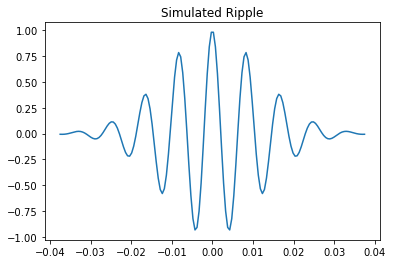

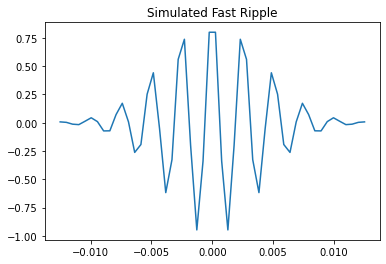

In [163]:
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_time, ripple_data)
plt.title("Simulated Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_time, fast_ripple_data)
plt.title("Simulated Fast Ripple")

## Add other simulated EEG data
These detectors work by finding patterns that deviate from the normal, so we need some "normal" EEG attached to the simulated HFO signal for the detectors to work. We can do this by grabbing a small segment of real EEG data from mne's samples.

In [159]:
%%capture
# Load in template data
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)
raw = raw.pick_channels(['EEG 001'])
sfreq = int(np.round(raw.info['sfreq']))
# Get two seconds of data to add before and after the HFO
raw_data_front = raw.get_data(start=0, stop=2*sfreq)[0]
raw_data_back = raw.get_data(start=2*sfreq, stop=4*sfreq)[0]
times = np.linspace(0, 2, 2*sfreq)

Text(0.5, 1.0, 'Raw Data Sample (Back)')

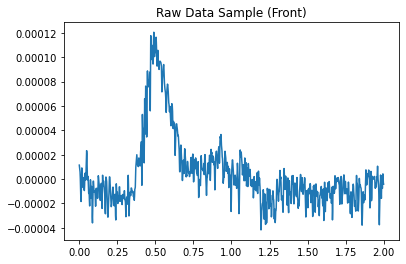

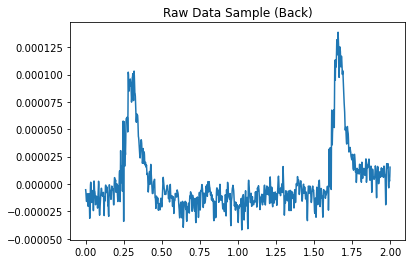

In [160]:
# Visualize the raw data
fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_front)
plt.title("Raw Data Sample (Front)")

fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_back)
plt.title("Raw Data Sample (Back)")
#plt.plot(times, raw_data_back)

## Combine the simulated data with sample data

In [167]:
def change_scale(val, aim_min, aim_max, cur_min, cur_max):
    return (val - cur_min) * (aim_max - aim_min) / (cur_max - cur_min) + aim_min

In [168]:
# Normalize ripple data scale to that of the sample data
sig_min = np.min([np.min(raw_data_front), np.min(raw_data_back)])
sig_max = np.max([np.max(raw_data_front), np.max(raw_data_back)])
ripple_min = np.min(ripple_data)
ripple_max = np.max(ripple_data)
fast_ripple_min = np.min(fast_ripple_data)
fast_ripple_max = np.max(fast_ripple_data)

ripple_data = [change_scale(r, sig_min, sig_max, ripple_min, ripple_max) for r in ripple_data]
fast_ripple_data = [change_scale(r, sig_min, sig_max, fast_ripple_min, fast_ripple_max) for r in fast_ripple_data]

In [175]:

# Combine the datasets and create new time vectors
ripple_data_total = np.concatenate((raw_data_front, ripple_data, raw_data_back))
t_total = len(raw_data_front) + len(ripple_data) + len(raw_data_back)
ripple_times_total = np.linspace(0, t_total/sfreq, t_total)

fast_ripple_data_total = np.concatenate((raw_data_front, fast_ripple_data, raw_data_back))
fast_t_total = len(raw_data_front) + len(fast_ripple_data) + len(raw_data_back)
fast_ripple_times_total = np.linspace(0, fast_t_total/sfreq, fast_t_total)


Text(0.5, 1.0, 'Simulated data with Fast Ripple')

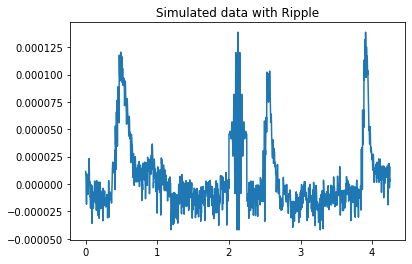

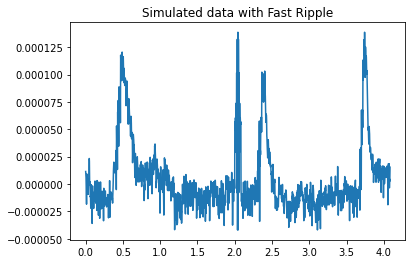

In [170]:
# Visualize
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_times_total, ripple_data_total)
plt.title("Simulated data with Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_times_total, fast_ripple_data_total)
plt.title("Simulated data with Fast Ripple")

In [176]:
# Reshape the data to fit detector requirements
ripple_data_total = ripple_data_total.reshape(1, len(ripple_data_total))
fast_ripple_data_total = fast_ripple_data_total.reshape(1, len(fast_ripple_data_total))

## Detect the HFOs

We have two detectors that can detect the presense of an HFO, a LineLengthDetector and an RMSDetector. We will plug the simulated data into each detector to demonstrate the presence of HFOs.

In [171]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
    'sfreq': 2000,  # Sampling frequency of data
}
ll_detector = LineLengthDetector(**kwargs)

In [177]:
# Detect HFOs in the raw data using the LineLengthDetector method.
# Return the class object with HFOs added
ll_detector = ll_detector.fit(ripple_data_total)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = ll_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the line-length of the data window per channel
hfo_event_array = ll_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
hfo_df = ll_detector.df

100%|██████████| 1/1 [00:00<00:00, 328.09it/s]


## Check Results
We should see a single HFO starting around 2 seconds and ending a small amount after

In [183]:
detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

Detected a ripple HFO starting at 2.038269550748752s and ending at 2.329450915141431s


## Repeat for RMS Detector
We should get almost the exact same result

In [184]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(ripple_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

100%|██████████| 1/1 [00:00<00:00, 813.64it/s]


Detected a ripple HFO starting at 2.038269550748752s and ending at 2.329450915141431s


## Repeat for the fast ripple dataset
We should expect similar results

In [186]:
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(fast_ripple_data_total)
chs_hfo_dict = ll_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    
# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(fast_ripple_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

100%|██████████| 1/1 [00:00<00:00, 1336.62it/s]

Detected a fast ripple HFO starting at 1.9550748752079867s and ending at 2.2462562396006653s


Detected a fast ripple HFO starting at 1.9550748752079867s and ending at 2.2462562396006653s


## More complex Example
Now let's combine the two datasets to show how the detectors differentiate the ripple types.

The detectors set to the ripple frequency band (80-250Hz) should only detect a single HFO (ripple) around the 2 second mark. The detectors set to the fast ripple frequency band (250-500Hz) should only detect a single HFO (fast ripple) around the 6 second mark (will vary based on the length of the ripple wave added).

(5008,) (5008, 1)


Text(0.5, 1.0, 'Simulated data with Ripple and Fast Ripple')

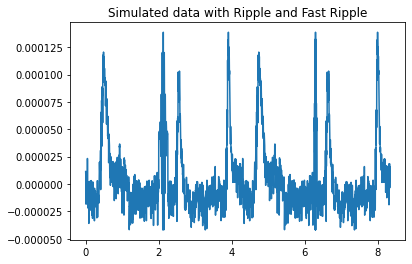

In [195]:
# Combine
hfo_data_total = np.concatenate((ripple_data_total, fast_ripple_data_total), axis=1)
hfo_times_total = np.linspace(0, hfo_data_total.shape[1]/sfreq, hfo_data_total.shape[1])

# Reshape just for plotting
hfo_data_total_plot = hfo_data_total.reshape(hfo_data_total.shape[1], 1)

# Plot
fig = plt.figure()
ax = plt.axes()
ax.plot(hfo_times_total, hfo_data_total_plot)
plt.title("Simulated data with Ripple and Fast Ripple")

In [197]:
# First look for ripples
# Line length Detector
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
chs_hfo_dict = ll_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    
# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

# Then look for fast ripples
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
chs_hfo_dict = ll_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    
# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

100%|██████████| 1/1 [00:00<00:00, 671.95it/s]


Detected a ripple HFO starting at 2.038269550748752s and ending at 2.329450915141431s using the LineLength Detector
Detected a ripple HFO starting at 2.038269550748752s and ending at 2.329450915141431s using the RMS detector


100%|██████████| 1/1 [00:00<00:00, 1346.05it/s]

Detected a fast ripple HFO starting at 6.239600665557404s and ending at 6.4891846921797s using the LineLength Detector
Detected a fast ripple HFO starting at 6.239600665557404s and ending at 6.4891846921797s using the RMS detector


Define dataset paths and load the data
--------------------------------------

The data is assumed to be in BIDS format. We have converted the dataset into BIDS, 
which you can load using [mne-bids](https://github.com/mne-tools/mne-bids).

In [2]:
# this may change depending on where you store the data
root = '/Users/patrick/Dropbox/fedele_hfo_data'

In [3]:
# print a boiler plate summary report using mne-bids
report = make_report(root, verbose=False)
print(report)

Summarizing participants.tsv /Users/patrick/Dropbox/fedele_hfo_data/participants.tsv...
The iEEG Interictal Asleep HFO Dataset dataset was created with BIDS version
1.4.0 by Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, and
Sarnthein J.. This report was generated with MNE-BIDS
(https://doi.org/10.21105/joss.01896). The dataset consists of 20 participants
(comprised of 13 men and 6 women; handedness were all unknown; ages ranged from
17.0 to 52.0 (mean = 32.47, std = 11.43; 1 with unknown age))and 1 recording
sessions: interictalsleep. Data was recorded using a iEEG system (Neuralynx
manufacturer) sampled at 2000.0 Hz with line noise at 50.0 Hz using Sampling
with parameters 2000 Downsampled (Hz). There were 385 scans in total. Recording
durations ranged from 204.0 to 720.0 seconds (mean = 302.44, std = 37.85), for a
total of 116438.81 seconds of data recorded over all scans. For each dataset,
there were on average 51.88 (std = 15.55) recording channels per scan, ou

In [4]:
# there are iEEG datatypes throughout the dataset
datatypes = get_datatypes(root)
print(datatypes)

# get all the subjects, sessions
subjects = get_entity_vals(root, 'subject')
sessions = get_entity_vals(root, 'session')

print(subjects)
print(sessions)

['ieeg']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
['interictalsleep']


In [5]:
# construct BIDSPath for dataset we will demo
subjectID = subjects[0]
sessionID = sessions[0]
bids_path = BIDSPath(subject=subjectID, session=sessionID,
                     datatype='ieeg', 
                     suffix='ieeg',
                     extension='.vhdr', root=root)

# get all matching datasets
fpaths = bids_path.match()

print(f'Found {len(fpaths)} matching filepaths for this subject and session.')

Found 28 matching filepaths for this subject and session.


In [6]:
# analyze the first run
dataset_path = fpaths[0]
print(dataset_path)

# count the different HFO types (fr, ripple, frandr) that were detected using 
# the published Morphology detector
counts_df = count_events(dataset_path)
display(counts_df)

/Users/patrick/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_ieeg.vhdr


NaN                                        \
trial_type                  fr_AHR1-2 fr_AHR2-3 fr_AHR3-4 fr_AL1-2 fr_AL2-3   
subject session         run                                                   
01      interictalsleep 01         15        23        12       15       19   

                                                                          ...  \
trial_type                  fr_AL3-4 fr_AR1-2 fr_AR2-3 fr_AR3-4 fr_HL1-2  ...   
subject session         run                                               ...   
01      interictalsleep 01        20       25       28       11        9  ...   

                                                                       \
trial_type                  ripple_IAR2-3 ripple_IAR3-4 ripple_IAR4-5   
subject session         run                                             
01      interictalsleep 01            351           223           179   

                                                                       \
trial_type                  ripple_IAR5-6 ripple_IPR1-2 ripple_IPR2-3   
subject session         run                                             
01      interictalsleep 01            238            12            32   

                                                                       \
trial_type                  ripple_IPR3-4 ripple_PHR1-2 ripple_PHR2-3   
subject session         run                                             
01      interictalsleep 01            128           121           111   

                                           
trial_type                  ripple_PHR3-4  
subject session         run                
01      interictalsleep 01             64  

[1 rows x 60 columns]

In [7]:
# load dataset into mne Raw object
raw = read_raw_bids(dataset_path)
print(raw)

Extracting parameters from /Users/patrick/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/patrick/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_events.tsv.
Reading channel info from /Users/patrick/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_channels.tsv.
<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 50 x 600000 (300.0 s), ~56 kB, data not loaded>


<ipython-input-7-591b67558c6d>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(dataset_path)
<ipython-input-7-591b67558c6d>:2: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-interictalsleep_run-01.

The search_str was "/Users/patrick/Dropbox/fedele_hfo_data/sub-01/**/sub-01_ses-interictalsleep*electrodes.tsv"
  raw = read_raw_bids(dataset_path)
<ipython-input-7-591b67558c6d>:2: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-interictalsleep_run-01.

The search_str was "/Users/patrick/Dropbox/fedele_hfo_data/sub-01/**/sub-01_ses-interictalsleep*coordsystem.json"
  raw = read_raw_bids(dataset_path)


In [ ]:
# Optional - Change backend to interactive for below plot
# Allows you to scroll dataset, highlight (or grey out) certain channels, zoom in/out, etc.
%matplotlib notebook

In [ ]:
# Plot the raw data with vertical colorbars to denote where HFOs were detected
raw_plot = raw.plot()
raw_plot.show()
print('plotting channels with HFO events detected in '
      'the original publication in color.')

In [ ]:
# Optional - Change back to regular plots
%matplotlib inline

In [ ]:
print(f'Data has sampling rate of {raw.info["sfreq"]} Hz')

Line Length Detector
--------------------

In [8]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 500), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
}
detector = LineLengthDetector(**kwargs)

In [9]:
# Detect HFOs in the raw data using the LineLengthDetector method.
# Return the class object with HFOs added
hfo_detector = detector.fit(raw)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = hfo_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the line-length of the data window per channel
hfo_event_array = hfo_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
hfo_df = hfo_detector.df

100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


In [11]:
print(hfo_df)

         onset             duration  sample trial_type
0          6.0               0.0625   12000   hfo_IAR1
1        7.175               0.0625   14350   hfo_IAR1
2        9.125               0.0625   18250   hfo_IAR1
3         10.0               0.0625   20000   hfo_IAR1
4      15.8625               0.0625   31725   hfo_IAR1
...        ...                  ...     ...        ...
1467   199.975  0.07500000000001705  399950   hfo_PHR8
1468  218.7875  0.07500000000001705  437575   hfo_PHR8
1469   231.875  0.07499999999998863  463750   hfo_PHR8
1470  244.9375  0.07499999999998863  489875   hfo_PHR8
1471    256.75               0.0625  513500   hfo_PHR8

[1472 rows x 4 columns]


RMS Detector
------------

In [12]:
# Set Key Word Arguments for the RMS Detector and generate the class object
kwargs = {
    'filter_band': (80, 500), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
}
detector = RMSDetector(**kwargs)

In [13]:
# Detect HFOs in the raw data using the RMSDetector method.
# Return the class object with HFOs added
hfo_detector = detector.fit(raw)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = hfo_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the RMS of the data window per channel
hfo_event_array = hfo_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
hfo_df = hfo_detector.df

100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


In [14]:
print(chs_hfo_dict)

{'IAR1': [(14950, 15100), (18975, 19100), (19300, 19450), (23700, 23825), (29525, 29650), (30550, 30700), (33200, 33325), (40600, 40725), (57100, 57250), (57225, 57375), (58975, 59100), (84800, 84925), (94650, 94775), (102500, 102650), (122950, 123075), (136575, 136700), (138900, 139050), (149450, 149600), (151075, 151200), (153825, 153950), (169800, 169925), (184525, 184650), (193225, 193350), (211875, 212000), (218300, 218425), (223250, 223400), (232575, 232700), (243350, 243475), (265375, 265525), (306500, 306675), (307000, 307150), (308675, 308800), (312025, 312150), (331275, 331425), (356550, 356675), (367600, 367725), (424850, 424975), (428750, 428875), (463675, 463800), (465900, 466050), (546250, 546375)], 'IAR2': [(6000, 6125), (8700, 8825), (9250, 9375), (10650, 10775), (14700, 14825), (15625, 15750), (15775, 15925), (16375, 16525), (18750, 18875), (23375, 23500), (24700, 24850), (25325, 25450), (40575, 40700), (41700, 41825), (46925, 47100), (55050, 55175), (55975, 56100), (6

# Reproducing Results Using Morphology Detector

Here, we will reproduce to the best of our ability the results published using the morphology detector. We will show the results on the bipolar reference and also compare to the published results only using the subset of channels they selected.

Later on, we will then show the results for the other channels. 

In [21]:
# detector parameters
# First detect ripples (80-250Hz)
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
}
detector = RMSDetector(**kwargs)

In [34]:
# Switch to subject 4 as in figure 1 in the paper
subjectID = subjects[3]
sessionID = sessions[0]
bids_path = BIDSPath(subject=subjectID, session=sessionID,
                     datatype='ieeg', 
                     suffix='ieeg',
                     extension='.vhdr', root=root)

# get all matching datasets
fpaths = bids_path.match()

print(f'Found {len(fpaths)} matching filepaths for this subject and session.')

Found 34 matching filepaths for this subject and session.


In [37]:
# analyze the first run
dataset_path = fpaths[2]
print(dataset_path)

# count the different HFO types (fr, ripple, frandr) that were detected using 
# the published Morphology detector
counts_df = count_events(dataset_path)
display(counts_df)

/Users/patrick/Dropbox/fedele_hfo_data/sub-04/ses-interictalsleep/ieeg/sub-04_ses-interictalsleep_run-03_ieeg.vhdr


NaN                                      \
trial_type                  fr_AL1-2 fr_AL2-3 fr_AL3-4 fr_AR1-2 fr_AR2-3   
subject session         run                                                
04      interictalsleep 03        15       19       19      164      108   

                                                                          ...  \
trial_type                  fr_AR3-4 fr_EL1-2 fr_EL2-3 fr_EL3-4 fr_ER1-2  ...   
subject session         run                                               ...   
04      interictalsleep 03        21       11       18       11       21  ...   

                                                                    \
trial_type                  ripple_HL3-4 ripple_HR1-2 ripple_HR2-3   
subject session         run                                          
04      interictalsleep 03           173          326          284   

                                                                    \
trial_type                  ripple_HR3-4 ripple_PL1-2 ripple_PL2-3   
subject session         run                                          
04      interictalsleep 03           204          311          646   

                                                                    \
trial_type                  ripple_PL3-4 ripple_PR1-2 ripple_PR2-3   
subject session         run                                          
04      interictalsleep 03           101           89           25   

                                          
trial_type                  ripple_PR3-4  
subject session         run               
04      interictalsleep 03             4  

[1 rows x 59 columns]

In [44]:
# load dataset into mne Raw object
raw = read_raw_bids(dataset_path)
# Subset channels as the paper did
ch_subset = ['IAR1', 'IAR2', 'IAR3', 'IAR4', 'IAR5', 'IAR6', 'IPR1', 'IPR2', 'IPR3', 'IPR4', 'AHR1', 'AHR2', 'AHR3',
             'AHR4','AL1', 'AL2', 'AL3', 'AL4', 'AR1', 'AR2', 'AR3', 'AR4', 'HL1', 'HL2', 'HL3', 'HL4', 'PHR1',
            'PHR2', 'PHR3', 'PHR4']
raw = raw.pick_channels(ch_subset)

Extracting parameters from /Users/patrick/Dropbox/fedele_hfo_data/sub-04/ses-interictalsleep/ieeg/sub-04_ses-interictalsleep_run-03_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/patrick/Dropbox/fedele_hfo_data/sub-04/ses-interictalsleep/ieeg/sub-04_ses-interictalsleep_run-03_events.tsv.
Reading channel info from /Users/patrick/Dropbox/fedele_hfo_data/sub-04/ses-interictalsleep/ieeg/sub-04_ses-interictalsleep_run-03_channels.tsv.


<ipython-input-44-273eb99bec4a>:2: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-interictalsleep_run-03.

The search_str was "/Users/patrick/Dropbox/fedele_hfo_data/sub-04/**/sub-04_ses-interictalsleep*electrodes.tsv"
  raw = read_raw_bids(dataset_path)
<ipython-input-44-273eb99bec4a>:2: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-interictalsleep_run-03.

The search_str was "/Users/patrick/Dropbox/fedele_hfo_data/sub-04/**/sub-04_ses-interictalsleep*coordsystem.json"
  raw = read_raw_bids(dataset_path)


In [45]:
# Fit the new data
hfo_detector = detector.fit(raw)
# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = hfo_detector.chs_hfos_

100%|██████████| 12/12 [00:00<00:00, 125.14it/s]


In [23]:
print(chs_hfo_dict)


{'IAR1': [(2525, 2650), (11725, 11850), (12000, 12125), (14950, 15100), (18975, 19125), (19300, 19450), (23700, 23825), (27650, 27775), (27950, 28075), (29525, 29650), (30550, 30700), (31725, 31850), (32200, 32325), (33200, 33350), (40600, 40750), (44500, 44625), (45150, 45275), (49125, 49250), (56850, 56975), (57050, 57175), (57100, 57250), (57225, 57375), (58975, 59100), (67575, 67725), (74350, 74475), (81075, 81200), (81750, 81875), (82325, 82450), (88475, 88600), (92375, 92500), (93050, 93175), (94650, 94800), (102500, 102650), (105425, 105550), (109725, 109850), (118775, 118900), (121350, 121475), (136575, 136725), (138900, 139050), (149450, 149600), (151050, 151200), (158525, 158650), (166550, 166675), (169800, 169925), (184525, 184650), (193200, 193350), (201000, 201125), (211875, 212000), (218300, 218450), (223275, 223400), (232575, 232700), (240000, 240125), (243350, 243475), (249300, 249425), (265375, 265525), (278750, 278875), (280650, 280775), (284450, 284575), (306500, 306

In [19]:
def calculate_events_per_min(raw, events):
    sfreq = raw.info['sfreq']
    total_samps = raw.n_times
    total_minutes = total_samps / (sfreq * 60.0)
    return len(events) / total_minutes

In [46]:
for key, val in chs_hfo_dict.items():
    print(f"Events per min for {key}: {calculate_events_per_min(raw, val)}")

Events per min for AL1: 7.4
Events per min for AL2: 8.0
Events per min for AL3: 8.0
Events per min for AL4: 8.0
Events per min for AR1: 26.6
Events per min for AR2: 20.8
Events per min for AR3: 10.6
Events per min for AR4: 7.8
Events per min for HL1: 6.4
Events per min for HL2: 10.0
Events per min for HL3: 10.4
Events per min for HL4: 5.6


In [41]:
# detector parameters
# Next detect Fast Ripples HFOs (250-500Hz)
kwargs = {
    'filter_band': (250, 500), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
}
detector = RMSDetector(**kwargs)

In [42]:
# Fit the new data
hfo_detector = detector.fit(raw)
# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = hfo_detector.chs_hfos_

100%|██████████| 64/64 [00:09<00:00,  6.61it/s]


In [43]:
for key, val in chs_hfo_dict.items():
    print(f"Events per min for {key}: {calculate_events_per_min(raw, val)}")

Events per min for AL1: 7.4
Events per min for AL2: 8.0
Events per min for AL3: 8.0
Events per min for AL4: 8.0
Events per min for AL5: 8.2
Events per min for AL6: 8.4
Events per min for AL7: 9.6
Events per min for AL8: 11.8
Events per min for AR1: 26.6
Events per min for AR2: 20.8
Events per min for AR3: 10.6
Events per min for AR4: 7.8
Events per min for AR5: 7.6
Events per min for AR6: 7.8
Events per min for AR7: 8.2
Events per min for AR8: 9.0
Events per min for EL1: 7.6
Events per min for EL2: 8.2
Events per min for EL3: 7.2
Events per min for EL4: 8.2
Events per min for EL5: 0.8
Events per min for EL6: 8.6
Events per min for EL7: 11.6
Events per min for EL8: 1.2
Events per min for ER1: 8.2
Events per min for ER2: 7.6
Events per min for ER3: 6.4
Events per min for ER4: 7.2
Events per min for ER5: 6.2
Events per min for ER6: 6.6
Events per min for ER7: 7.4
Events per min for ER8: 7.4
Events per min for HL1: 6.4
Events per min for HL2: 10.0
Events per min for HL3: 10.4
Events per mi